In [1]:
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid, RasterModelGrid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
    LinearDiffuser
)

from landlab.plot import imshow_grid

%matplotlib inline

# Simple example using Linear Diffuser & Stream Power components
No uplift,
not considering precipitation

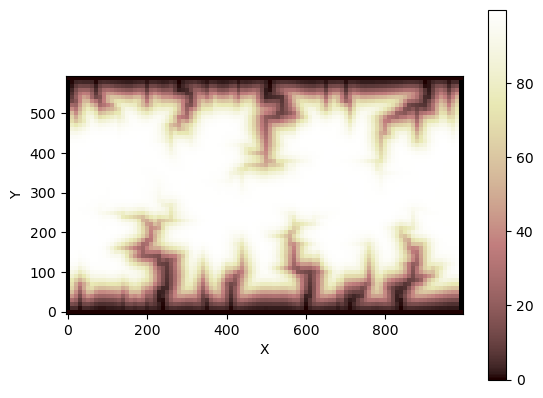

In [2]:
# PARAMS
K = 0.0005  # stream power coefficient, bigger = streams erode more quickly
U = 0.0004  # uplift rate in meters per year

dt = 1000  # time step in years
dx = 10  # space step in meters

nr = 60  # number of model rows
nc = 100  # number of model columns

# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

D = 0.001  # Hillslope diffusivity and m2 per years


#create grid
grid = RasterModelGrid((nr, nc), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)
# add a topographic__elevation field with noise
z = grid.add_zeros("topographic__elevation", at="node")
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

#imshow_grid(grid, "topographic__elevation")

# initializing flow accumulator
fr = FlowAccumulator(grid, depression_finder="DepressionFinderAndRouter", routing="D4")

# initializing stream power incision
spr = StreamPowerEroder(
    grid, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0
)  

# initializing linear diffuser
dd = LinearDiffuser(
    grid,
    linear_diffusivity=D,
)

# Run this model for multiple iterations
for i in range(200):
    # Flow Accumulator
    fr.run_one_step()
    # Stream Power
    spr.run_one_step(dt)
    # linear Diffuser
    dd.run_one_step(dt)

    #z[grid.core_nodes] += U * dt

# plot the final topography
imshow_grid(grid, "topographic__elevation")

Vary diffusivity spatially

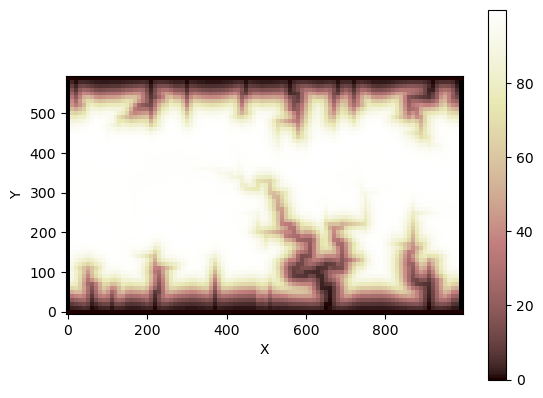

In [3]:
# PARAMS
K = 0.0005  # stream power coefficient, bigger = streams erode more quickly
U = 0.0004  # uplift rate in meters per year

dt = 1000  # time step in years
dx = 10  # space step in meters

nr = 60  # number of model rows
nc = 100  # number of model columns

# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

D = 0.001  # Hillslope diffusivity and m2 per years


# rate of EQs
rate = np.array([0, 0, 0.01, 0.01, 0, 0, 0.01, 0.01, 0, 0, 0.01, 0.01, 0])


#create grid
grid = RasterModelGrid((nr, nc), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)
# add a topographic__elevation field with noise
z = grid.add_zeros("topographic__elevation", at="node")
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

#imshow_grid(grid, "topographic__elevation")

# initializing flow accumulator
fr = FlowAccumulator(grid, depression_finder="DepressionFinderAndRouter", routing="D4")

# initializing stream power incision
spr = StreamPowerEroder(
    grid, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0
)  

# initializing linear diffuser
dd = LinearDiffuser(
    grid,
    linear_diffusivity=D,
)

# Run this model for multiple iterations
for i in range(200):
    # Flow Accumulator
    fr.run_one_step()
    # Stream Power
    spr.run_one_step(dt)
    # linear Diffuser
    dd.run_one_step(dt)

    #z[grid.core_nodes] += U * dt

# plot the final topography
imshow_grid(grid, "topographic__elevation")

# Linear Diffuser example with varying k

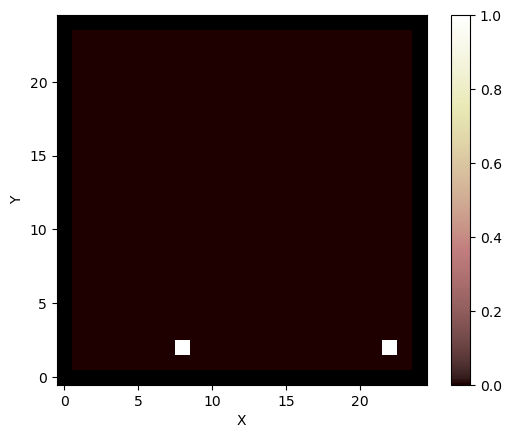

In [4]:
from landlab import RasterModelGrid
import numpy as np

mg2 = RasterModelGrid((25, 25))
z2 = mg2.add_zeros("topographic__elevation", at="node")
z2.reshape((25, 25))[2, 8] = 1.
z2.reshape((25, 25))[2, 22] = 1.
mg2.set_closed_boundaries_at_grid_edges(True, True, True, True)
imshow_grid(mg2,"topographic__elevation")

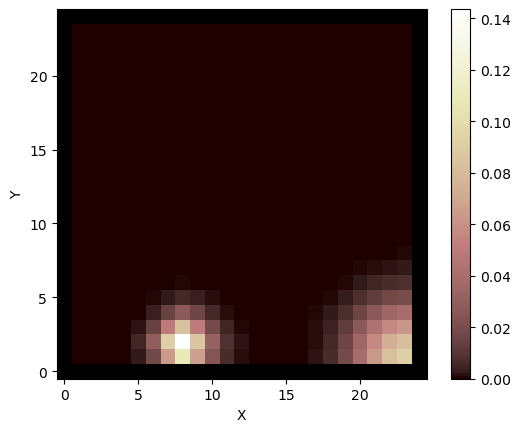

In [5]:
#print(mg2.node_x)
#print(mg2.node_x.mean())
kd = mg2.node_x/mg2.node_x.mean()

#print(kd)

ld2 = LinearDiffuser(mg2, linear_diffusivity=kd)
for i in range(10):
    ld2.run_one_step(0.1)
z2[mg2.core_nodes].sum() == 2.

z2.reshape((25, 25))[2, 8] > z2.reshape((25, 25))[2, 22]
imshow_grid(mg2, "topographic__elevation")

# Stream Power Eroder -- using water_unit_flux_in

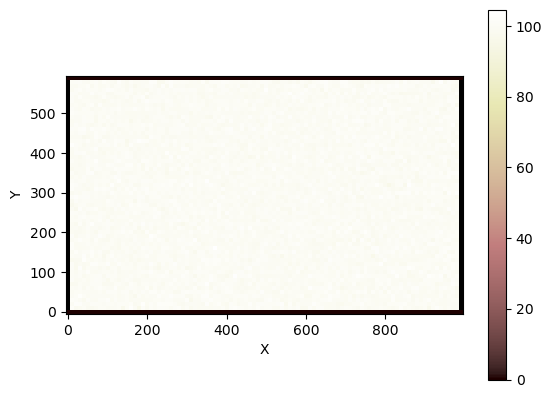

In [71]:
mg3 = RasterModelGrid((60, 100), xy_spacing=10)
mg3.set_closed_boundaries_at_grid_edges(True, False, True, False)

# add a topographic__elevation field with noise
z = mg3.add_zeros("topographic__elevation", at="node")
z[mg3.core_nodes] += 100.0 + np.random.randn(mg3.core_nodes.size)

imshow_grid(mg3,"topographic__elevation")

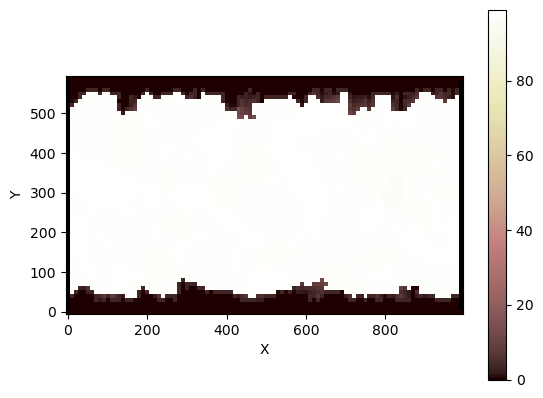

In [72]:
# P(z) = P0 + aP0z
# P0 = 80
# a = [1/2.2, 1/1.1]

P0 = 80
a = 1/2.2

K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

mg3.add_zeros("water__unit_flux_in",at="node")
mg3.at_node["water__unit_flux_in"][:] = P0 + a*P0*z #mg3.node_y

# params for flow accumulator
fr3 = FlowAccumulator(mg3, depression_finder="DepressionFinderAndRouter", routing="D4")
sp3 = StreamPowerEroder(
    mg3,
    K_sp=0.0005,
    discharge_field="surface_water__discharge")
for i in range(3):
    fr3.run_one_step()
    sp3.run_one_step(1000)
imshow_grid(mg3,"topographic__elevation")

In [48]:
mg3.at_node["water__unit_flux_in"]

array([ 80.,  80.,  80., ...,  80.,  80.,  80.])

# Combined Diffusion & StreamPower with Orographic effect

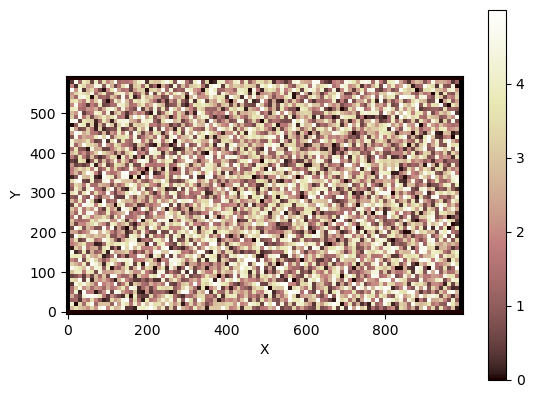

In [101]:
mg3 = RasterModelGrid((60, 100), xy_spacing=10)
mg3.set_closed_boundaries_at_grid_edges(True, False, True, False)

# add a topographic__elevation field with noise
np.random.seed(0)
z = mg3.add_zeros("topographic__elevation", at="node")
z[mg3.core_nodes] += 0 + np.random.rand(mg3.core_nodes.size)*5

imshow_grid(mg3,"topographic__elevation")

In [102]:
## Stream Power
# P(z) = P0 + aP0z
# P0 = 80
# a = [1/2.2, 1/1.1]

dt = 100 # timestep
P0 = 80
a = 1/2.2
U = 0.05 # uplift

K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

mg3.add_zeros("water__unit_flux_in",at="node")
mg3.at_node["water__unit_flux_in"][:] = P0 + a*P0*z

# params for flow accumulator
fr3 = FlowAccumulator(mg3, depression_finder="DepressionFinderAndRouter", routing="D4")
sp3 = StreamPowerEroder(
    mg3,
    K_sp=0.0005,
    discharge_field="surface_water__discharge")

## Diffusion 
D = (P0 + a*P0*z) *0.001
ld = LinearDiffuser(mg3, linear_diffusivity=D)


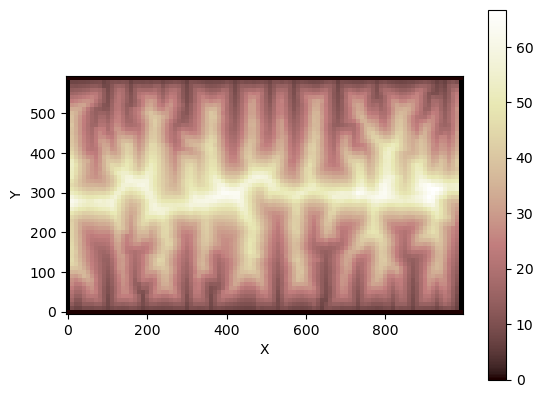

In [103]:
for i in range(30):
    fr3.run_one_step() # Flow Accumulator
    sp3.run_one_step(dt) # StreamPower FastScape Eroder
    ld.run_one_step(dt) # Linear Diffuser
    z[mg3.core_nodes] += U * dt
imshow_grid(mg3,"topographic__elevation")

# Combined Diffusion & StreamPower without Orographic Effect

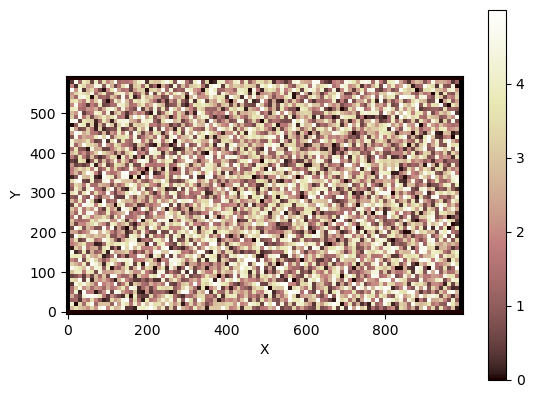

In [116]:
mg3 = RasterModelGrid((60, 100), xy_spacing=10)
mg3.set_closed_boundaries_at_grid_edges(True, False, True, False)

# add a topographic__elevation field with noise
np.random.seed(0)
z = mg3.add_zeros("topographic__elevation", at="node")
z[mg3.core_nodes] += 0 + np.random.rand(mg3.core_nodes.size)*5

imshow_grid(mg3,"topographic__elevation")

In [118]:
## Stream Power

dt = 100 # timestep
U = 0.05 # uplift

K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

mg3.add_zeros("water__unit_flux_in",at="node")
mg3.at_node["water__unit_flux_in"][:] = P0 + a*P0*np.mean(z)

# params for flow accumulator
fr3 = FlowAccumulator(mg3, depression_finder="DepressionFinderAndRouter", routing="D4")



sp3 = StreamPowerEroder(
    mg3,
    K_sp=0.0005,
    discharge_field="surface_water__discharge")

## Diffusion 
D = (P0 + a*P0*np.mean(z))*0.001 
ld = LinearDiffuser(mg3, linear_diffusivity=D)


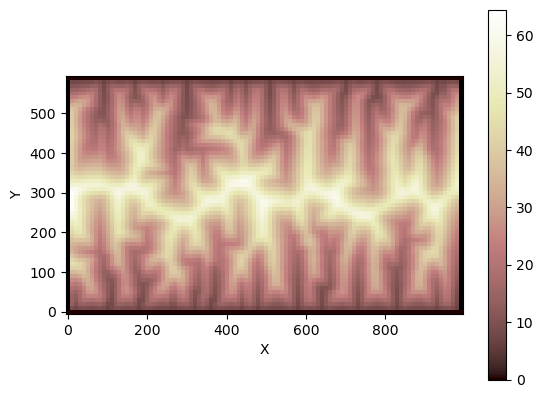

In [ ]:
for i in range(30):
    fr3.run_one_step() # Flow Accumulator
    sp3.run_one_step(dt) # StreamPower FastScape Eroder
    ld.run_one_step(dt) # Linear Diffuser
    z[mg3.core_nodes] += U * dt
imshow_grid(mg3,"topographic__elevation")